# Import Libraries

In [406]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import re

# Handle miss values and categorical data

In [407]:
TrainData=pd.read_csv("train_submissions.csv")
TrainData['user_id'] = TrainData['user_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)
TrainData['problem_id'] = TrainData['problem_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)

In [409]:
UserData=pd.read_csv("user_data.csv")
UserData['user_id'] = UserData['user_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)
UserData['country'] = UserData['country'].astype('category')
UserData['country'] = UserData['country'].cat.codes #miss value is 0
UserData['country']=UserData['country'].replace(-1,0)#miss value replace with 0
UserData["contribution"]=(UserData["contribution"]-UserData["contribution"].min())/UserData["contribution"].max()
UserData["rank"]=UserData["rank"].replace(['beginner','intermediate','advanced','expert'],[1,2,3,4])
#UserData['last_online_time_hours']=UserData['last_online_time_seconds']/3600
#UserData['registration_time_hours']=UserData['registration_time_seconds']/3600
UserData['last_online_time_seconds']=(UserData['last_online_time_seconds']-UserData['last_online_time_seconds'].min())/(UserData['last_online_time_seconds'].max()-UserData['last_online_time_seconds'].min())
UserData['registration_time_seconds']=(UserData['registration_time_seconds']-UserData['registration_time_seconds'].min())/(UserData['registration_time_seconds'].max()-UserData['registration_time_seconds'].min())
#UserData=UserData.drop('last_online_time_seconds',axis=1)
#UserData=UserData.drop('registration_time_seconds',axis=1)

In [410]:
ProblemData=pd.read_csv("problem_data.csv")
ProblemData['problem_id'] = ProblemData['problem_id'].apply(lambda x: re.search(r'\d+', x).group()).astype(int)
ProblemData=ProblemData.drop("tags", axis=1)
ProblemData.fillna(ProblemData.mean(), inplace=True)
ProblemData.dropna(inplace=True)
ProblemData["level_type"]=ProblemData["level_type"].replace(['A' ,"B","C","D","E","F","G","H","I","J","K","L","M","N"],
                                                           [ 1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ProblemData['points']=(ProblemData['points']-ProblemData['points'].min())/(ProblemData['points'].max()-ProblemData['points'].min())


In [484]:
df=TrainData.set_index('problem_id').join(ProblemData.set_index('problem_id'))
df.reset_index(inplace=True)
df=df.set_index('user_id').join(UserData.set_index('user_id'))
df.reset_index(inplace=True)
df.dropna(inplace=True)

# Visualize

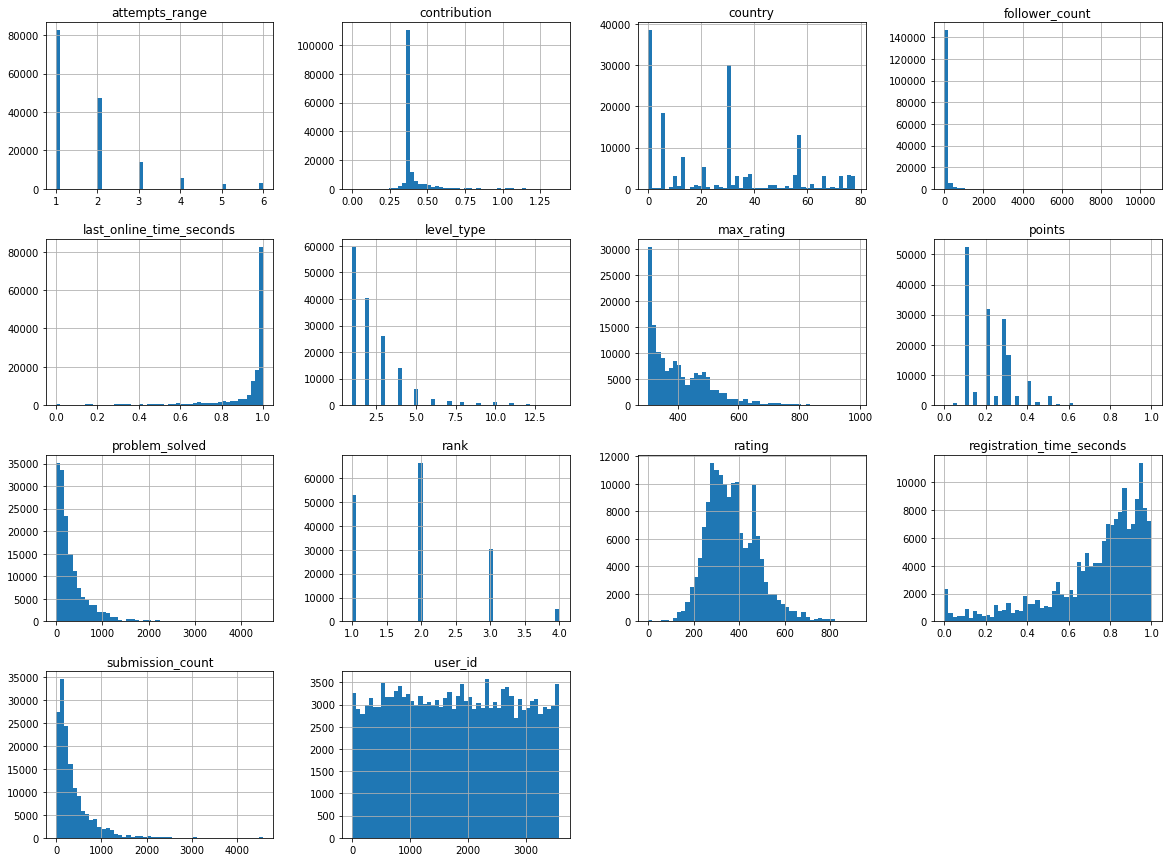

In [412]:
df.hist(bins=50, figsize=(20,15))
plt.show()

# Feature selection

### 1.SelectKBest

In [461]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X = df.drop(["attempts_range","user_id"],axis=1)  #independent columns
y = df["attempts_range"]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

               Specs         Score
7     follower_count  72067.368657
3   submission_count  46987.658859
4     problem_solved  45327.350232
0         problem_id  25194.986527
10            rating  15786.467436
9         max_rating  12598.415340
1         level_type   3677.159487
6            country   1703.581541
2             points    343.803399
11              rank    136.418818


### 2.Feature Importance

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.52047263 0.06661096 0.07659751 0.03936222 0.03911804 0.02369937
 0.03006433 0.03854369 0.03974233 0.04093296 0.04113447 0.00282958
 0.04089192]


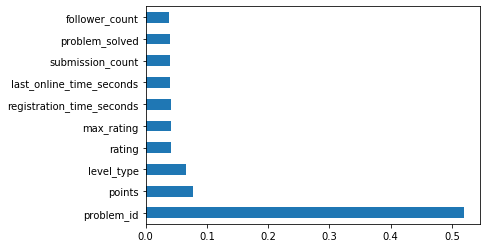

In [492]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### 3.Correlation Matrix with Heatmap

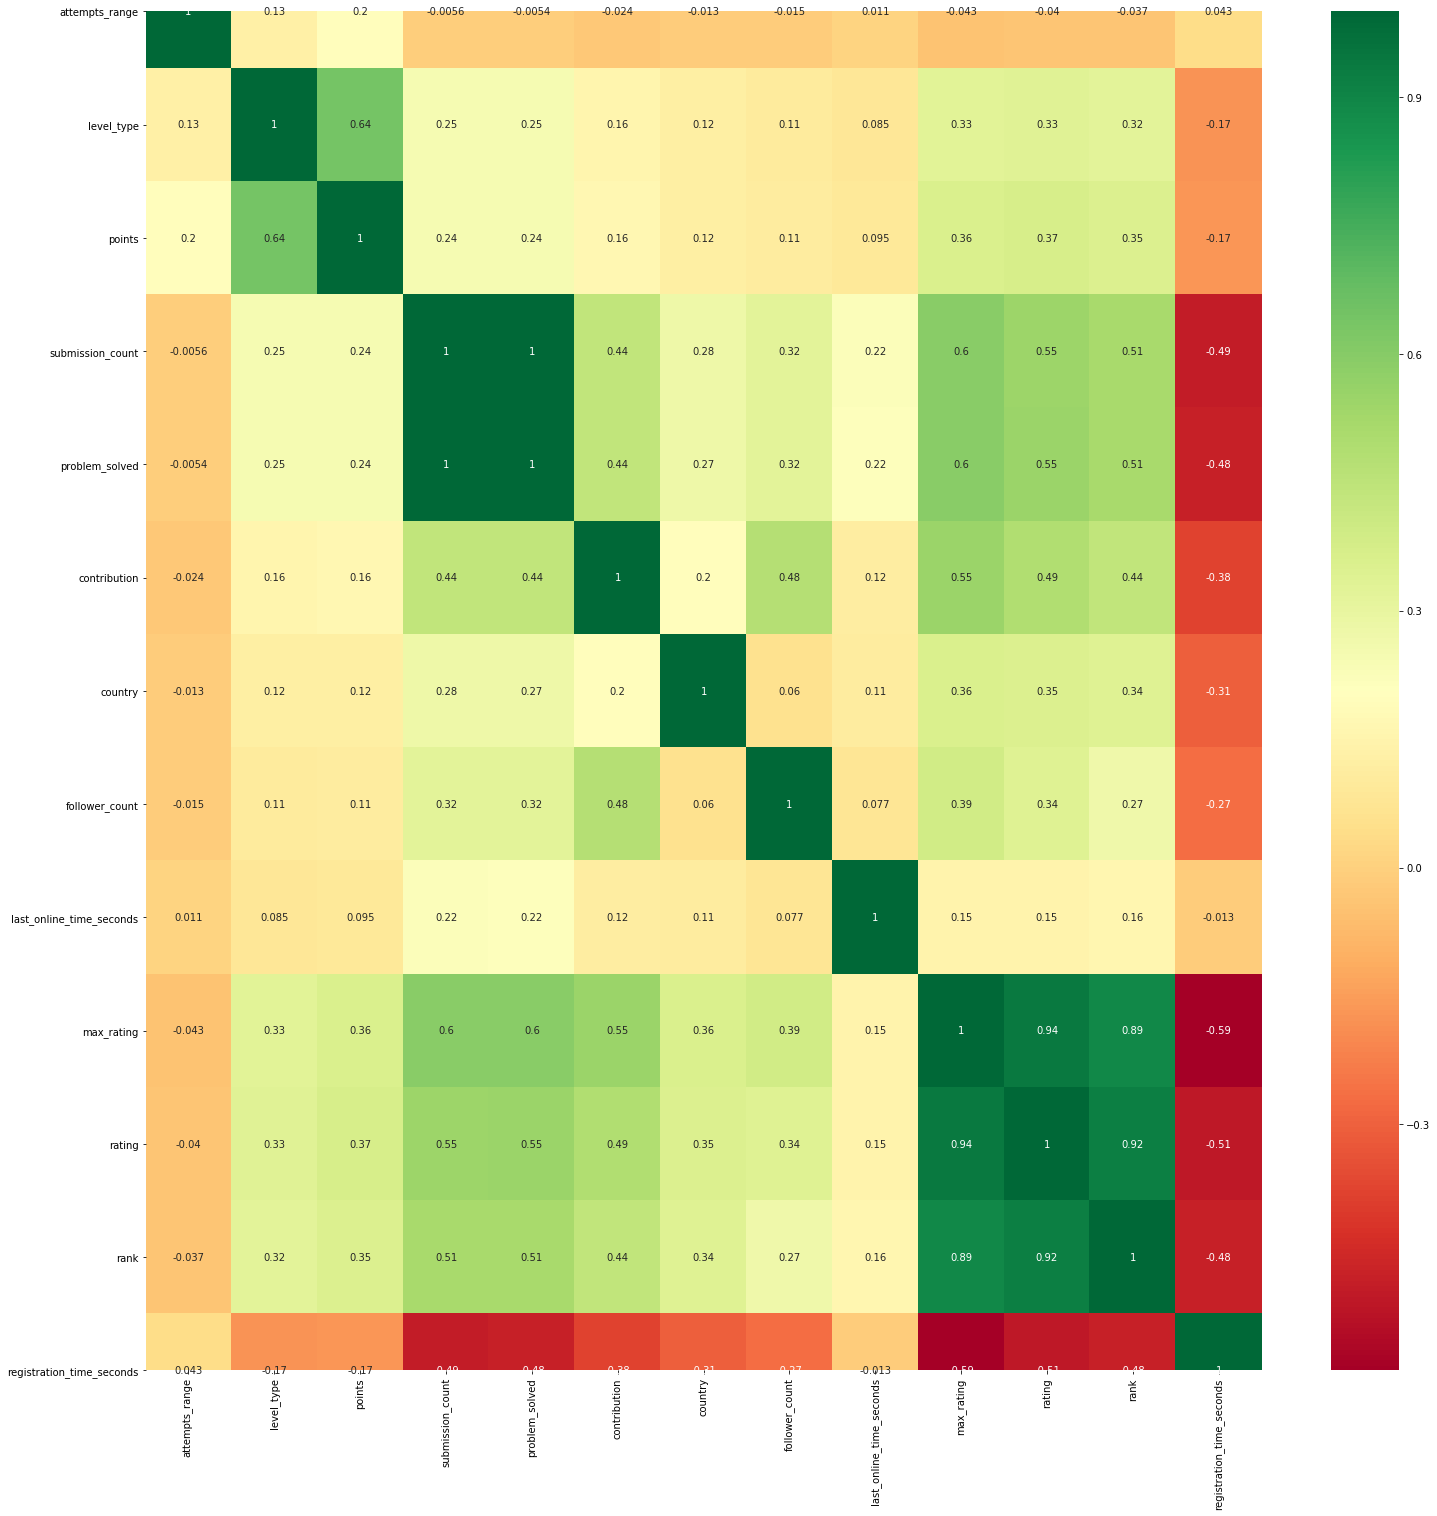

In [415]:
#df=df.drop("user_id",axis=1)
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,25))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [493]:
X1=df.drop(['user_id', 'attempts_range', 'contribution', 'last_online_time_seconds',
       'registration_time_seconds'],axis=1)
X2=df.drop(['user_id', 'attempts_range',
        'contribution', 'country',
       'follower_count', 'max_rating',
       'rank'],axis=1)
#X3=df.drop(['attempts_range'],axis=1)

# Multiclass Classification

### 1.SGD Classifer

In [494]:
from sklearn.linear_model import SGDClassifier
sgd_clf1 = SGDClassifier(random_state=42)
sgd_clf1.fit(X1, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [495]:
scores1 = sgd_clf1.decision_function(np.array(X1.iloc[34500]).reshape(1, -1))
scores1

array([[-2071.65241064,  1701.4949243 , -2854.56063607, -4937.71052342,
        -1571.34192096, -1870.99246365]])

In [496]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf1, X1, y, cv=3, scoring="accuracy")

array([0.38745903, 0.03985725, 0.24161608])

In [497]:
sgd_clf2 = SGDClassifier(random_state=42)
sgd_clf2.fit(X2, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [498]:
scores2 = sgd_clf2.decision_function(np.array(X2.iloc[34500]).reshape(1, -1))
scores2

array([[ -926.96859274,    99.73495621, -1736.26243075, -2876.88429612,
        -3006.84004919,  -594.83374081]])

In [499]:
cross_val_score(sgd_clf2, X2, y, cv=5, scoring="accuracy")

array([0.30675243, 0.38608741, 0.32080168, 0.32313959, 0.53027511])

### 2.Random Forest

In [500]:
from sklearn.ensemble import RandomForestClassifier
forest_clf1 = RandomForestClassifier(random_state=42)
forest_clf1.fit(X1, y)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [501]:
forest_clf1.predict_proba(np.array(X1.iloc[34500]).reshape(1, -1))

array([[0.9, 0.1, 0. , 0. , 0. , 0. ]])

In [502]:
cross_val_score(forest_clf1, X1, y, cv=5, scoring="accuracy")

array([0.49633125, 0.50788725, 0.5051883 , 0.49702593, 0.49481137])

In [503]:
forest_clf2 = RandomForestClassifier(random_state=42)
forest_clf2.fit(X2, y)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [504]:
forest_clf2.predict_proba(np.array(X2.iloc[34500]).reshape(1, -1))

array([[0.8, 0.2, 0. , 0. , 0. , 0. ]])

In [505]:
cross_val_score(forest_clf2, X2, y, cv=5, scoring="accuracy")

array([0.49891715, 0.51021464, 0.49907871, 0.50245684, 0.49597517])

# Error Analysis

In [506]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred1 = cross_val_predict(forest_clf1, X1, y, cv=3)
conf_mx1 = confusion_matrix(y, y_pred1)
conf_mx1

array([[64793, 15850,  1368,   274,    81,   110],
       [33284, 12203,  1222,   240,    54,   132],
       [ 9280,  4143,   498,    92,    16,    53],
       [ 3496,  1679,   211,    42,    17,    33],
       [ 1531,   797,   127,    17,     5,     7],
       [ 1802,  1010,   147,    36,     7,    18]], dtype=int64)

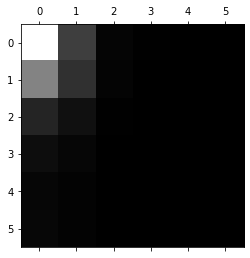

In [507]:
plt.matshow(conf_mx1, cmap=plt.cm.gray)
plt.show()

In [508]:
y_pred2 = cross_val_predict(forest_clf2, X2, y, cv=3)
conf_mx2 = confusion_matrix(y, y_pred2)
conf_mx2

array([[65252, 15432,  1309,   278,    83,   122],
       [33528, 12053,  1117,   234,    77,   126],
       [ 9279,  4157,   483,    88,    31,    44],
       [ 3484,  1690,   228,    37,     8,    31],
       [ 1523,   830,   101,    18,     2,    10],
       [ 1836,   999,   131,    21,    10,    23]], dtype=int64)

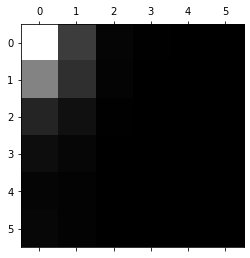

In [509]:
plt.matshow(conf_mx2, cmap=plt.cm.gray)
plt.show()

In [510]:
y_pred3 = cross_val_predict(sgd_clf1, X1, y, cv=3)
conf_mx3 = confusion_matrix(y, y_pred3)
conf_mx3

array([[17484, 20781, 18194,    12, 26005,     0],
       [ 8377, 12715, 11100,    14, 14929,     0],
       [ 2097,  3980,  3494,     6,  4505,     0],
       [  762,  1521,  1434,     0,  1761,     0],
       [  367,   691,   629,     1,   796,     0],
       [  442,   881,   736,     0,   961,     0]], dtype=int64)

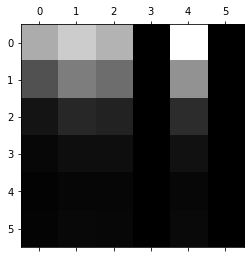

In [511]:
plt.matshow(conf_mx3, cmap=plt.cm.gray)
plt.show()

In [512]:
y_pred4 = cross_val_predict(sgd_clf2, X2, y, cv=3)
conf_mx4 = confusion_matrix(y, y_pred4)
conf_mx4

array([[16567, 26503, 38983,   417,     6,     0],
       [ 8057, 15419, 23363,   288,     8,     0],
       [ 2008,  4723,  7249,    99,     3,     0],
       [  721,  1879,  2855,    21,     2,     0],
       [  365,   850,  1251,    17,     1,     0],
       [  419,  1015,  1564,    20,     2,     0]], dtype=int64)

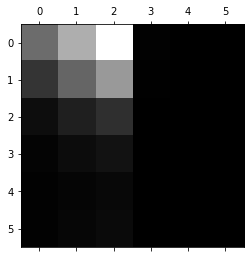

In [513]:
plt.matshow(conf_mx4, cmap=plt.cm.gray)
plt.show()